In [69]:
from kinpred.dataset import df_to_molentry_list, split_molentry_list, KinPredGraphClassDataLoader, map_target_to_vals, MolEntry
from kinpred.model import freeze_module, unfreeze_module
from kinpred.model import Encoder, Decoder, Discriminator
from kinpred.utils import AverageMeter, mol_to_nx
from kinpred.gnn_models import LigandModel

from rdkit import Chem
from rdkit.Chem import AllChem
from torch_geometric.data import Batch
from torch_geometric.utils import from_networkx
from tqdm import tqdm 
from typing import Tuple, List 
import collections
import itertools
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import operator
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.set_num_threads(8)

In [2]:
# Read in the data 
df = pd.read_csv("kinase_JAK.csv")
df.head()

,SMILES,measurement_type,measurement_value,Kinase_name
0,C#CCCOC(=O)N1CCC(n2cc(C(N)=O)c(Nc3ccc(F)cc3)n2...,pIC50,6.81,JAK2
1,C#CCCOC(=O)N1CCC(n2cc(C(N)=O)c(Nc3ccc(F)cc3)n2...,pIC50,8.05,JAK1
2,C#CCN(c1ccc(C#N)cn1)C1CCN(c2ncnc3[nH]ccc23)C1,pIC50,10.26,JAK2
3,C#CCN(c1ccc(C#N)cn1)C1CCN(c2ncnc3[nH]ccc23)C1,pIC50,10.26,JAK1
4,C#CCNCC1CCC(c2nnn3cnc4[nH]ccc4c23)CC1,pIC50,7.36,JAK2


In [58]:
mol_list, targets = df_to_molentry_list(df)
print(f"Number of samples: {len(mol_list)}")

Number of samples: 4528


In [5]:
## Pre-Load all MolEntry Objects using multiprocessing

from concurrent.futures import ThreadPoolExecutor, as_completed

def load_molentry(entry):
    entry.to_fp()
    return True

with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(load_molentry, entry) for entry in mol_list]
    for future in tqdm(as_completed(futures), total=len(futures)):
        pass

with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(load_molentry, entry) for entry in sample_df]
    for future in tqdm(as_completed(futures), total=len(futures)):
        pass


100%|██████████| 100/100 [00:01<00:00, 95.59it/s]


In [59]:
# Sample ~100 random SMILES strings from the dataset and save them to a separate mol list for furtur testing
smiles = df["SMILES"].sample(100, replace=False)
sample_df = [mol for mol in mol_list if mol.smiles in smiles.values]
# remove samples from mol_list 
mol_list = [mol for mol in mol_list if mol.smiles not in smiles.values]
print(f"Number of samples: {len(mol_list)}")
print(f"Number of samples: {len(sample_df)}")

Number of samples: 4428
Number of samples: 100


In [ ]:
train, test = split_molentry_list(mol_list, test_size=0.35)
train_loader = KinPredGraphClassDataLoader(train, batch_size=64, shuffle=True, num_workers=0, device="cpu", include_fp=True)
test_loader = KinPredGraphClassDataLoader(test, batch_size=64, shuffle=True, num_workers=0, device="cpu", include_fp=True)
model = LigandModel(in_channels=18,edge_features=6,hidden_dim=128,residual_layers=4,mlp_layers=3,\
                    key_dim=1024,dropout_rate=0.15).double()
model.train()

In [17]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)
mse_criterion = nn.MSELoss()
bce_criterion = nn.BCEWithLogitsLoss()

In [ ]:
for i in range(150):
    train_loss = AverageMeter()
    test_loss = AverageMeter()
    model.train()
    for batch in train_loader:
        feats, labels, targets, fps = batch
        optim.zero_grad()
        out_energy, out_labels = model(feats, fps)
        loss = 0.5*(mse_criterion(F.relu(out_energy), targets) + bce_criterion(out_labels, labels))
        # loss = mse_criterion(F.relu(out_energy), targets)
        train_loss.update(loss.item())
        loss.backward()
        optim.step()
    with torch.no_grad():
        model.eval()
        for batch in test_loader:
            feats, labels, targets, fps = batch
            out_energy, out_labels = model(feats, fps)
            loss = 0.5*(mse_criterion(F.relu(out_energy), targets) + bce_criterion(out_labels, labels))
            # loss = mse_criterion(F.relu(out_energy), targets)
            test_loss.update(loss.item())
    print(f"Epoch {i} Train Loss: {train_loss} Test Loss: {test_loss}")
    

In [ ]:
# save neural network
torch.save(model.state_dict(), "kinpred/weights/GNN/gnn_model.pth")

## Evaluate the Graph Neural Network

In [ ]:
# Load the model
model.load_state_dict(torch.load("kinpred/weights/GNN/gnn_model.pth"))
model.eval()

In [63]:
# Test R2 accuracy
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, accuracy_score, roc_auc_score
from scipy.stats import pearsonr

Energy R2:  0.841416299903285
Energy MAE:  0.5514365903302495
Energy Pearson:  PearsonRResult(statistic=0.9531710093385087, pvalue=0.0)
Labels Accuracy:  0.9732258064516129
Labels AUC:  0.9836182157453703


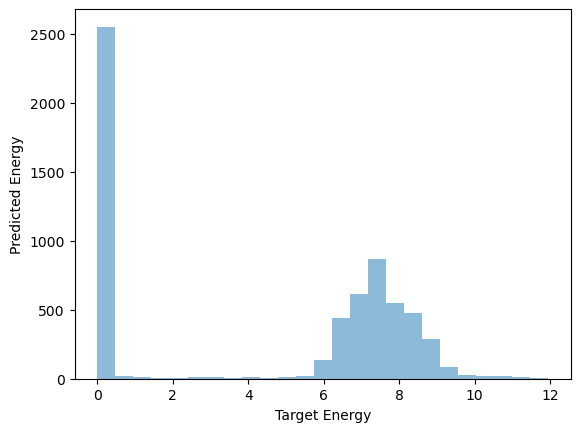

In [67]:
target_energy, target_labels, out_energy, out_labels = [],[],[],[]

with torch.no_grad():
    model.eval()
    for batch in test_loader:
        feats, labels, targets, fps = batch
        out_e, out_l = model(feats, fps)
        out_energy.append(F.relu(out_e).detach().numpy())
        out_labels.append(torch.sigmoid(out_l).detach().numpy())
        target_energy.append(targets.detach().numpy())
        target_labels.append(labels.detach().numpy())

out_energy = np.vstack(out_energy)
out_labels = np.vstack(out_labels)
target_energy = np.vstack(target_energy)
target_labels = np.vstack(target_labels)

print("Energy R2: ", r2_score(target_energy, out_energy))
print("Energy MAE: ", mean_absolute_error(target_energy, out_energy))
print("Energy Pearson: ", pearsonr(target_energy.flatten(), out_energy.flatten()))

print("Labels Accuracy: ", accuracy_score(target_labels.flatten(), out_labels.flatten().round()))
print("Labels AUC: ", roc_auc_score(target_labels.flatten(), out_labels.flatten()))

# plt.scatter(target_energy.flatten(), out_energy.flatten())
plt.hist(out_energy.flatten(), bins=25, alpha=0.5, label="Output Energy")
plt.xlabel("Target Energy")
plt.ylabel("Predicted Energy")
plt.show()


These results show how the model learned the underlying features that constituted a selective binder by using molecular fingerprints and graph neural networks. It is able to predict the binding affinity to within a mean absolute error of 0.55 kcal/mol. This is a significant improvement over the MLP models, which would have required 4 separate copies and did not show well correlated results. Lets explore how well it does on the 100 samples we removed early on to make sure the model has not been trained on them.

Energy R2:  0.8015602658900649
Energy MAE:  0.6302745896665746
Energy Pearson:  PearsonRResult(statistic=0.9453278544105759, pvalue=8.933875331128324e-196)
Labels Accuracy:  0.9775
Labels AUC:  0.9901769301470589


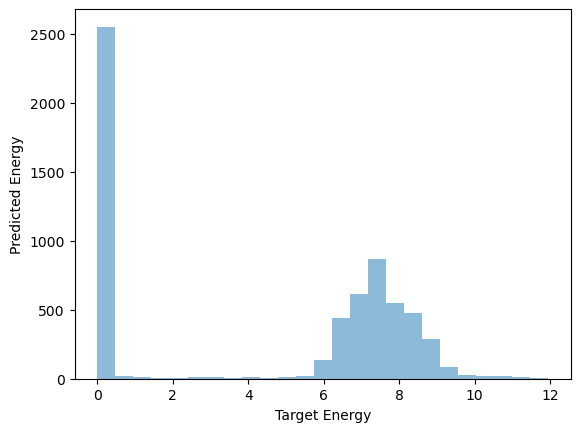

In [68]:
true_scores = []
true_predictions = []
sample_scores = []
sample_predictions = []

for mol in sample_df:
    mol.to_fp()
    mol_graph = Batch.from_data_list([from_networkx(mol_to_nx(mol.to_mol()))])
    fingerprint = torch.from_numpy(np.array([mol.to_fp()]))
    true_cls, true_ene = map_target_to_vals(mol)
    outenergy, outcls = model(mol_graph, fingerprint)
    true_scores.append(true_ene)
    true_predictions.append(true_cls)
    sample_scores.append(outenergy.detach().numpy())
    sample_predictions.append(torch.sigmoid(outcls).detach().numpy())
    
true_scores = np.vstack(true_scores)
true_predictions = np.vstack(true_predictions)
sample_scores = np.vstack(sample_scores)
sample_predictions = np.vstack(sample_predictions)


print("Energy R2: ", r2_score(true_scores, sample_scores))
print("Energy MAE: ", mean_absolute_error(true_scores, sample_scores))
print("Energy Pearson: ", pearsonr(true_scores.flatten(), sample_scores.flatten()))

print("Labels Accuracy: ", accuracy_score(true_predictions.flatten(), sample_predictions.flatten().round()))
print("Labels AUC: ", roc_auc_score(true_predictions.flatten(), sample_predictions.flatten()))

# plt.scatter(true_scores.flatten(), sample_scores.flatten())
plt.hist(out_energy.flatten(), bins=25, alpha=0.5, label="Output Energy")
plt.xlabel("Target Energy")
plt.ylabel("Predicted Energy")
plt.show()



This GNN performs well on the data that has been provided for us, but what about Out of Distribution data? We can verify this model's accuracy by examining a few molecules pulled from literature. 

Selected Molecules: 
* [WP1066](https://www.selleckchem.com/products/wp1066.html) - inhibitor of JAK2 and STAT3 with IC50 of 2.30 μM and 2.43 μM
* [Ruxolitinib](https://www.selleckchem.com/products/INCB18424.html) - JAK1/2 inhibitor to enter the clinic with IC50 of 3.3 nM/2.8 nM in cell-free assays, >130-fold selectivity for JAK1/2 versus JAK3
* [AZD1480](https://www.selleckchem.com/products/AZD1480.html) - ATP-competitive JAK2 inhibitor with IC50 of 0.26 nM in a cell-free assay, selectivity against JAK3 and Tyk2, and to a smaller extent against JAK1
* [AT9283](https://www.selleckchem.com/products/AT9283.html) - potent JAK2/3 inhibitor with IC50 of 1.2 nM/1.1 nM
* [Deucravacitinib](https://www.selleckchem.com/products/bms-986165.html) - highly potent and selective allosteric inhibitor of Tyk2 with a Ki value of 0.02 nM for binding to the Tyk2 pseudokinase domain



In [71]:
WP1066 = MolEntry("CC(C1=CC=CC=C1)NC(=O)C(=CC2=NC(=CC=C2)Br)C#N", {"JAK2": 1})
Ruxolitinib = MolEntry("C1CCC(C1)C(CC#N)N2C=C(C=N2)C3=C4C=CNC4=NC=N3", {"JAK1": 1, "JAK2": 1})
AZD1480 = MolEntry("CC1=CC(=NN1)NC2=NC(=NC=C2Cl)NC(C)C3=NC=C(C=N3)F", {"JAK2": 1})
AT9283 = MolEntry("C1CC1NC(=O)NC2=C(NN=C2)C3=NC4=C(N3)C=C(C=C4)CN5CCOCC5", {"JAK2": 1, "JAK3": 1})
Deucravacitinib = MolEntry("CNC(=O)C1=NN=C(C=C1NC2=CC=CC(=C2OC)C3=NN(C=N3)C)NC(=O)C4CC4", {"TYK2": 1})
wild_mols = [WP1066, Ruxolitinib, AZD1480, AT9283, Deucravacitinib]

In [77]:
true_predictions = []
sample_scores = []
sample_predictions = []

for mol in wild_mols:
    mol.to_fp()
    mol_graph = Batch.from_data_list([from_networkx(mol_to_nx(mol.to_mol()))])
    fingerprint = torch.from_numpy(np.array([mol.to_fp()]))
    true_cls, true_ene = map_target_to_vals(mol)
    outenergy, outcls = model(mol_graph, fingerprint)
    true_predictions.append(true_cls)
    sample_scores.append(outenergy.detach().numpy())
    sample_predictions.append(torch.sigmoid(outcls).detach().numpy())
    
true_predictions = np.vstack(true_predictions)
sample_scores = np.vstack(sample_scores)
sample_predictions = np.vstack(sample_predictions)

print("Labels Accuracy: ", accuracy_score(true_predictions.flatten(), sample_predictions.flatten().round()))
print("Labels AUC: ", roc_auc_score(true_predictions.flatten(), sample_predictions.flatten()))

for i, mol in enumerate(wild_mols):
    print(mol.smiles, true_predictions[i], sample_predictions[i], sample_scores[i])
    print("")

Labels Accuracy:  0.7
Labels AUC:  0.7802197802197802
CC(C1=CC=CC=C1)NC(=O)C(=CC2=NC(=CC=C2)Br)C#N [0. 1. 0. 0.] [0.23207289 0.89950372 0.11521842 0.02481012] [0.         5.46490155 1.11242991 0.        ]

C1CCC(C1)C(CC#N)N2C=C(C=N2)C3=C4C=CNC4=NC=N3 [1. 1. 0. 0.] [0.99480154 0.75004214 0.99415839 0.0168655 ] [7.68297087 1.43142907 8.0877965  0.        ]

CC1=CC(=NN1)NC2=NC(=NC=C2Cl)NC(C)C3=NC=C(C=N3)F [0. 1. 0. 0.] [0.98536569 0.9912869  0.00398882 0.00615706] [7.18804671 7.24496545 0.         0.        ]

C1CC1NC(=O)NC2=C(NN=C2)C3=NC4=C(N3)C=C(C=C4)CN5CCOCC5 [0. 1. 1. 0.] [0.02615703 0.9749898  0.99155327 0.0192113 ] [0.         7.64357813 7.48894466 0.602629  ]

CNC(=O)C1=NN=C(C=C1NC2=CC=CC(=C2OC)C3=NN(C=N3)C)NC(=O)C4CC4 [0. 0. 0. 1.] [0.97482412 0.97159564 0.80368558 0.04876804] [6.23886682 7.08488249 4.58411717 1.54286922]



With an AUC of 0.78, the model has learned to generalize to OOD data. This is a good sign that the model is not overfitting to the training data, but it does lack predictive abilities for TYK2 only inhibitors. The last prediction showed the highest threshold predicition level for the TYK2 which matches the correct answer, however, it was not enough to reach a correct preditiction. This could be remedied by adding more TYK2 only inhibitors to the dataset, or by reducing the representations of the other targets to artificially balance the dataset.